In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import xgboost as xgb
import mysql.connector
from mysql.connector import Error
from scipy.stats import norm
import joblib

In [45]:
# Function to connect to the MySQL database
def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [46]:
# Function to execute query
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as err:
        print(f"Error: '{err}'")

In [47]:
# Connect to the database
connection = create_db_connection("localhost", "root", "", "sales_predic_sys")

MySQL Database connection successful


In [48]:
# Fetch data from the database
query = "SELECT * FROM sales_data"
result = execute_query(connection, query)

In [49]:
# Convert the result to a pandas DataFrame
df = pd.DataFrame(result, columns=['sales_cat', 'net_value', 'year', 'month'])

In [50]:
# Close the database connection
connection.close()

In [51]:
# Convert the result to a pandas DataFrame
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%B')
df['month_num'] = df['date'].dt.month
df['year_num'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['is_holiday_season'] = ((df['month_num'] == 11) | (df['month_num'] == 12)).astype(int)
df['days_in_month'] = df['date'].dt.days_in_month

In [52]:
# Feature Engineering
df['year_month'] = df['date'].dt.to_period('M')
df['sales_growth'] = df.groupby('sales_cat')['net_value'].pct_change()
df['cumulative_sales'] = df.groupby('sales_cat')['net_value'].cumsum()
df['sales_ma_3'] = df.groupby('sales_cat')['net_value'].rolling(window=3).mean().reset_index(0, drop=True)
df['sales_ma_6'] = df.groupby('sales_cat')['net_value'].rolling(window=6).mean().reset_index(0, drop=True)
df['sales_ma_12'] = df.groupby('sales_cat')['net_value'].rolling(window=12).mean().reset_index(0, drop=True)

In [53]:
# Lag features and rolling mean features
for lag in [1, 3, 6, 12]:
    df[f'net_value_lag_{lag}'] = df.groupby('sales_cat')['net_value'].shift(lag)
for window in [3, 6, 12]:
    df[f'net_value_rolling_mean_{window}'] = df.groupby('sales_cat')['net_value'].rolling(window=window).mean().reset_index(0, drop=True)

In [54]:
le = LabelEncoder()
df['sales_cat_encoded'] = le.fit_transform(df['sales_cat'])
df.dropna(inplace=True)

In [55]:
# Define features and target
features = ['year_num', 'month_num', 'sales_cat_encoded', 'quarter', 'is_holiday_season', 'days_in_month',
            'net_value_lag_1', 'net_value_lag_3', 'net_value_lag_6', 'net_value_lag_12',
            'net_value_rolling_mean_3', 'net_value_rolling_mean_6', 'net_value_rolling_mean_12',
            'sales_growth', 'cumulative_sales', 'sales_ma_3', 'sales_ma_6', 'sales_ma_12']

In [56]:
# Split the data into training and testing sets
train_df = df[df['year_num'] < 2023]
test_df = df[df['year_num'] == 2023]

In [57]:
X_train = train_df[features]
y_train = train_df['net_value']
X_test = test_df[features]
y_test = test_df['net_value']

In [58]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

In [59]:
# Create a pipeline with scaling and XGBoost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb_model)
])

In [60]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'xgb__n_estimators': [100, 500, 1000],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
}

In [61]:
# Set up RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [62]:
# Fit the model
xgb_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           grow_policy=None,
                                                           importance_ty...
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.6, 0.8,
                                                                  1.0],
                                        'xgb__learning_rate': [0.01, 0.1, 0.3],
                                        'xgb__max_depth': [3, 5, 7],
                                        'xgb__min_child_weight': [1, 3, 5],
                                        'xgb__n_estimators': [100, 500, 1000],
                                        'xgb__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [63]:
# Make predictions on the test set
xgb_predictions = xgb_random_search.predict(X_test)

In [64]:
# Calculate performance metrics
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

In [65]:
print(f"XGBoost MSE: {xgb_mse}")
print(f"XGBoost R-squared: {xgb_r2}")

XGBoost MSE: 105378906108818.56
XGBoost R-squared: 0.9067901472579171


In [66]:
# Feature importance
feature_importance = xgb_random_search.best_estimator_.named_steps['xgb'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
print(feature_importance_df)

                      feature  importance
10   net_value_rolling_mean_3    0.394764
15                 sales_ma_3    0.177230
13               sales_growth    0.167535
3                     quarter    0.043996
6             net_value_lag_1    0.037932
2           sales_cat_encoded    0.023617
11   net_value_rolling_mean_6    0.023107
0                    year_num    0.021401
1                   month_num    0.021280
12  net_value_rolling_mean_12    0.014203
17                sales_ma_12    0.014136
9            net_value_lag_12    0.013091
5               days_in_month    0.009764
8             net_value_lag_6    0.009490
14           cumulative_sales    0.009425
7             net_value_lag_3    0.008410
16                 sales_ma_6    0.005980
4           is_holiday_season    0.004640


In [67]:
# Calculate prediction intervals
def prediction_interval(y_true, y_pred, conf=0.95):
    residuals = y_true - y_pred
    std_resid = np.std(residuals)
    z_score = norm.ppf((1 + conf) / 2)
    margin_error = z_score * std_resid
    return y_pred - margin_error, y_pred + margin_error

lower, upper = prediction_interval(y_test, xgb_predictions)

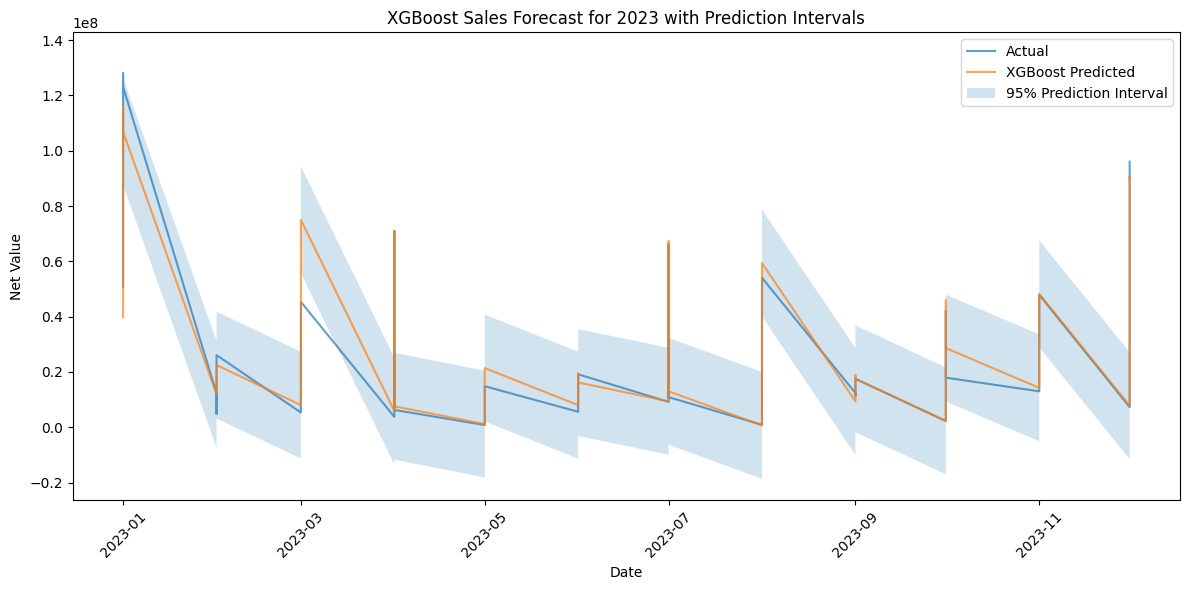

In [68]:
# Plot predictions with intervals for the test set (2023 data)
plt.figure(figsize=(12, 6))
plt.plot(test_df['date'], y_test, label='Actual', alpha=0.7)
plt.plot(test_df['date'], xgb_predictions, label='XGBoost Predicted', alpha=0.7)
plt.fill_between(test_df['date'], lower, upper, alpha=0.2, label='95% Prediction Interval')
plt.title('XGBoost Sales Forecast for 2023 with Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [77]:
# Function to predict net_value with intervals
def predict_net_value_with_intervals(year, month, sales_cat, percentile=95):
    input_df = pd.DataFrame({
        'year': [year],
        'month': [month],
        'sales_cat': [sales_cat]
    })
    
    # Preprocess input data
    input_df['date'] = pd.to_datetime(input_df['year'].astype(str) + '-' + input_df['month'], format='%Y-%B')
    input_df['month_num'] = input_df['date'].dt.month
    input_df['year_num'] = input_df['date'].dt.year
    input_df['quarter'] = input_df['date'].dt.quarter
    input_df['is_holiday_season'] = ((input_df['month_num'] == 11) | (input_df['month_num'] == 12)).astype(int)
    input_df['days_in_month'] = input_df['date'].dt.days_in_month
    input_df['sales_cat_encoded'] = le.transform([sales_cat])
    
    # Add engineered features
    input_df['sales_growth'] = 0  # You may want to use an average or recent growth rate
    input_df['cumulative_sales'] = df.groupby('sales_cat')['net_value'].sum().loc[sales_cat]
    input_df['sales_ma_3'] = df[df['sales_cat'] == sales_cat]['net_value'].tail(3).mean()
    input_df['sales_ma_6'] = df[df['sales_cat'] == sales_cat]['net_value'].tail(6).mean()
    input_df['sales_ma_12'] = df[df['sales_cat'] == sales_cat]['net_value'].tail(12).mean()
    
    # Add lag features
    for lag in [1, 3, 6, 12]:
        input_df[f'net_value_lag_{lag}'] = df[df['sales_cat'] == sales_cat]['net_value'].iloc[-lag]
    
    # Add rolling mean features
    for window in [3, 6, 12]:
        input_df[f'net_value_rolling_mean_{window}'] = df[df['sales_cat'] == sales_cat]['net_value'].tail(window).mean()
    
    # Ensure all features are present
    for feature in features:
        if feature not in input_df.columns:
            input_df[feature] = 0  # or some appropriate default value
    
    input_features = input_df[features]
    
    # Make prediction
    prediction = xgb_random_search.predict(input_features)
    
    # Calculate intervals
    std_resid = np.std(y_test - xgb_random_search.predict(X_test))
    z_score = norm.ppf((1 + percentile/100) / 2)
    interval = z_score * std_resid
    lower = prediction - interval
    upper = prediction + interval
    
    return prediction[0], lower[0], upper[0]

In [80]:
# Example usage
print("\nPredictions for 2024:")
print("Corporate:", predict_net_value_with_intervals(2024, 'April', 'Corporate'))
print("Retail:", predict_net_value_with_intervals(2024, 'April', 'Retail'))
print("Show Rooms:", predict_net_value_with_intervals(2024, 'April', 'Show Rooms'))


Predictions for 2024:
Corporate: (np.float32(7398746.5), np.float64(-11923462.151089523), np.float64(26720955.151089523))
Retail: (np.float32(67505630.0), np.float64(48183423.34891048), np.float64(86827840.65108952))
Show Rooms: (np.float32(62687588.0), np.float64(43365379.34891048), np.float64(82009796.65108952))


In [82]:
# Export the model
joblib.dump(xgb_random_search, 'joblibs/xgboost_sales_forecast_model.joblib')
print("Model exported successfully.")

Model exported successfully.
